In [50]:
%load_ext autoreload
%autoreload 2


import json
import os
import pkg_resources
# pkg_resources.require("numpy==1.19.5")
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster

from tslearn.clustering import TimeSeriesKMeans

import seaborn as sns


from ScheduleSampler import ScheduleSampler, activity_map, start_times, see_activities

filter_num=3
idle_sampling_factor=1.0


def time_human(time_mins):
    time_mins = int(round(time_mins))
    mins = time_mins%60
    time_mins = time_mins//60
    hrs = time_mins%24
    time_mins = time_mins//24
    days = time_mins
    h = '{:02d}:{:02d}'.format(hrs,mins)
    if days != 0:
        h = str(days)+'day - '+h
    return h

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


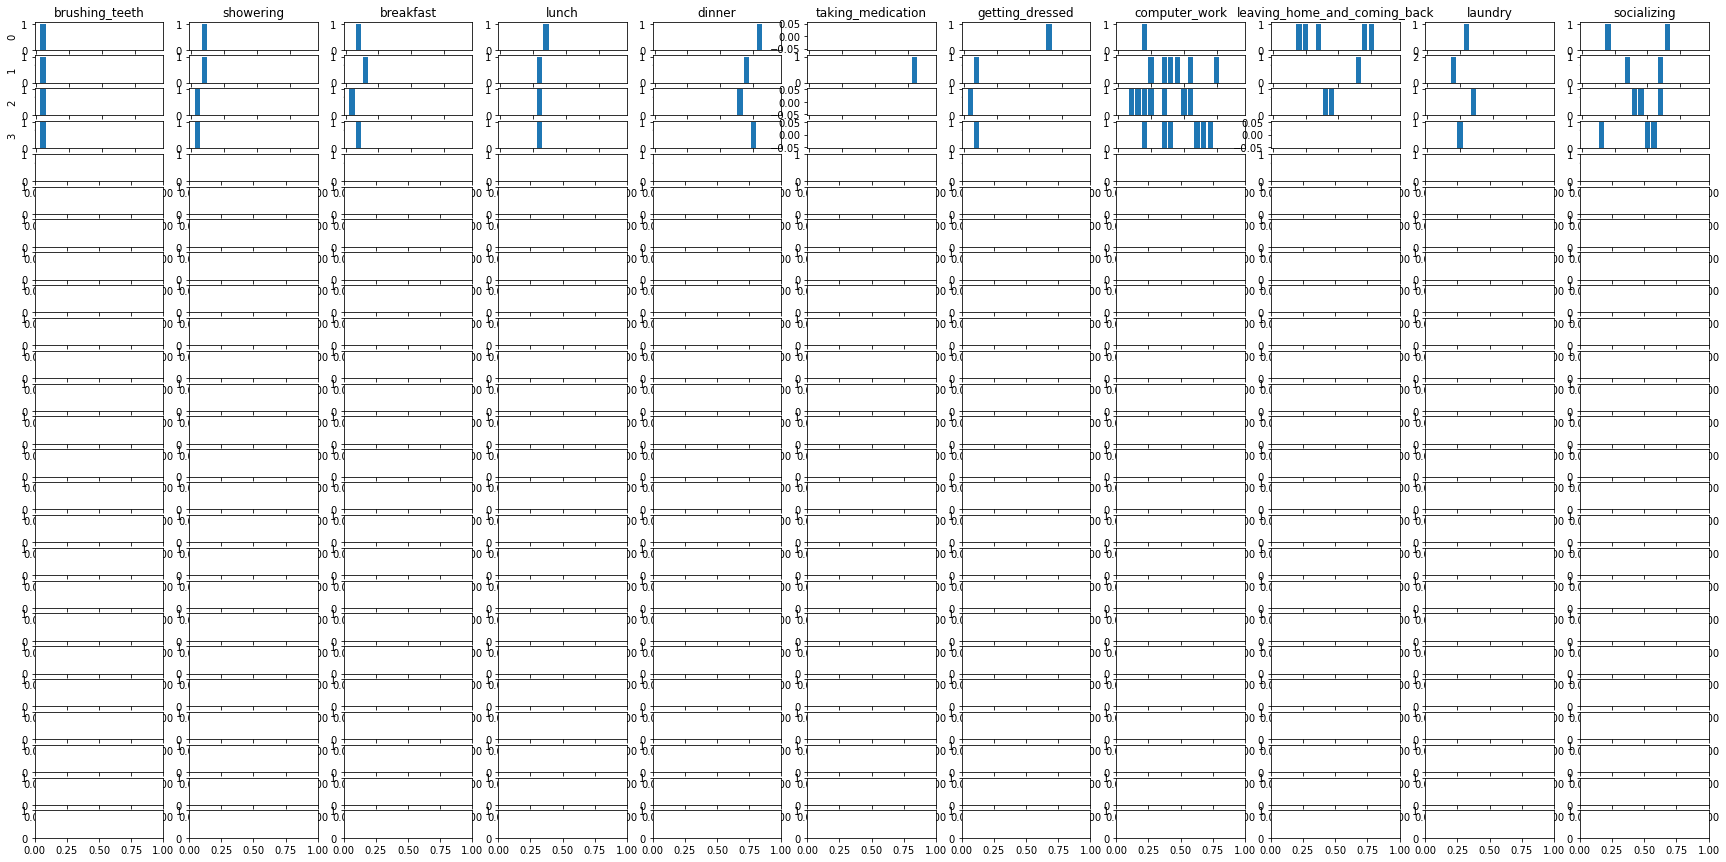

In [51]:
sampler = ScheduleSampler(filter_num=filter_num, idle_sampling_factor=idle_sampling_factor)

In [52]:
see_activities = list(activity_map.values())
see_activities.remove(None)
data_per_activity = {activity:{} for activity in see_activities}
ignore_datapoints = []#4, 20, 22]

for i, scene_hist in enumerate(sampler.scene_histogram):
    if i in ignore_datapoints:
        continue
    for activity in see_activities:
        data_list = list(scene_hist[activity].values())
        if max(data_list) > 0:
            data_per_activity[activity][i] = data_list

# num_clusters = {
#     "brushing_teeth":,
#     "showering":, 
#     "breakfast":,
#     "lunch":,
#     "dinner":,
#     "taking_medication":, 
#     "getting_dressed":, 
#     "computer_work":, 
#     "leaving_home_and_coming_back":, 
#     "laundry":, 
#     "socializing":
# }

clustering = {}
for activity in see_activities:
    clustering[activity] = {}

    cl = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=50).fit(np.array(list(data_per_activity[activity].values())))
    
    clustering[activity]['labels'] = cl.labels_
    clustering[activity]['centers'] = cl.cluster_centers_
   

TypeError: 'NoneType' object is not subscriptable

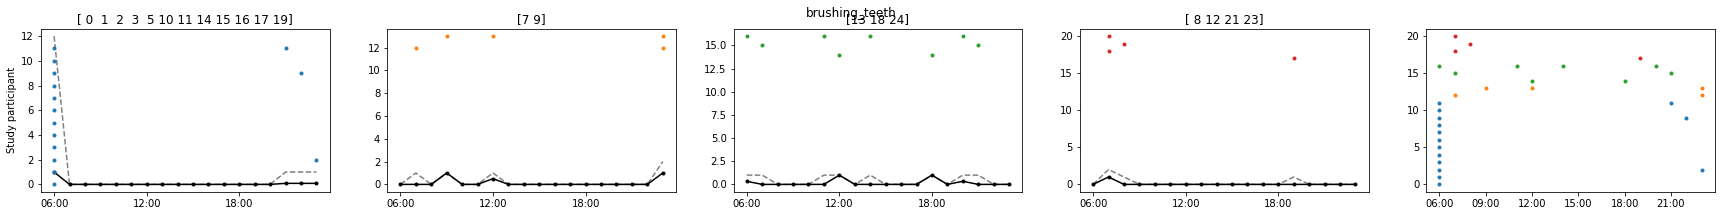

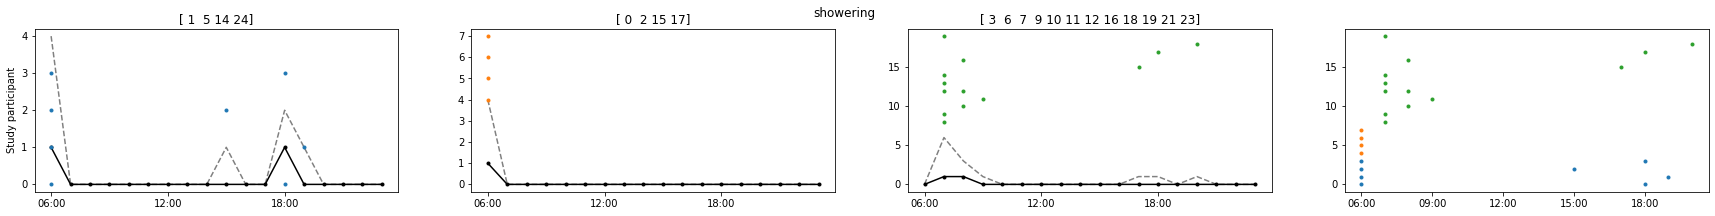

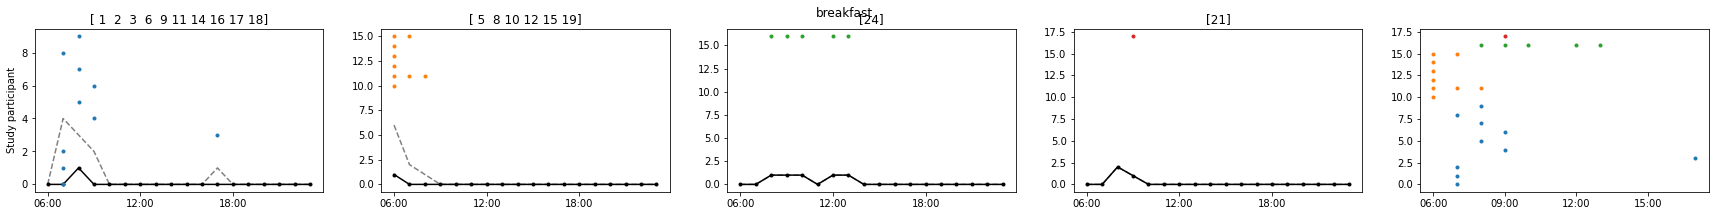

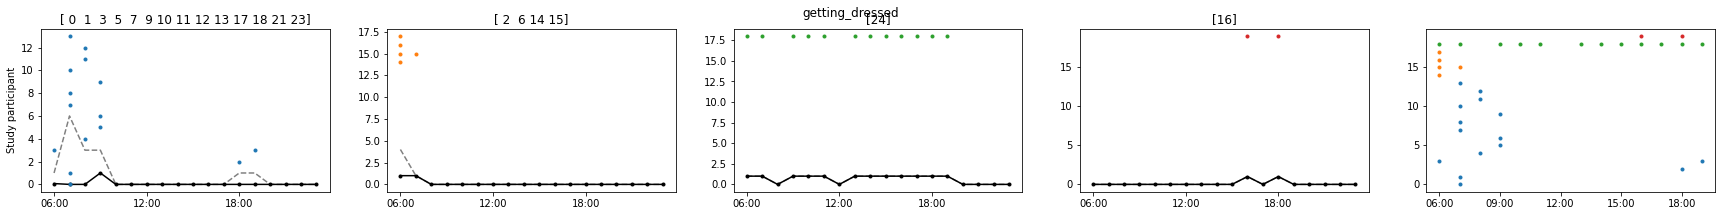

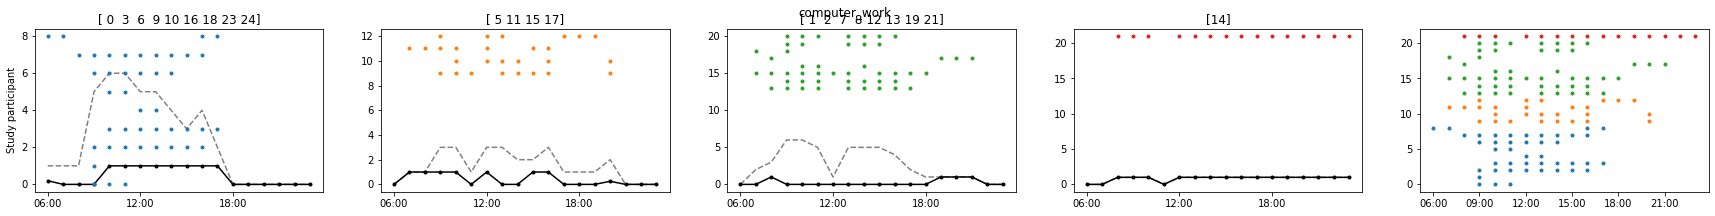

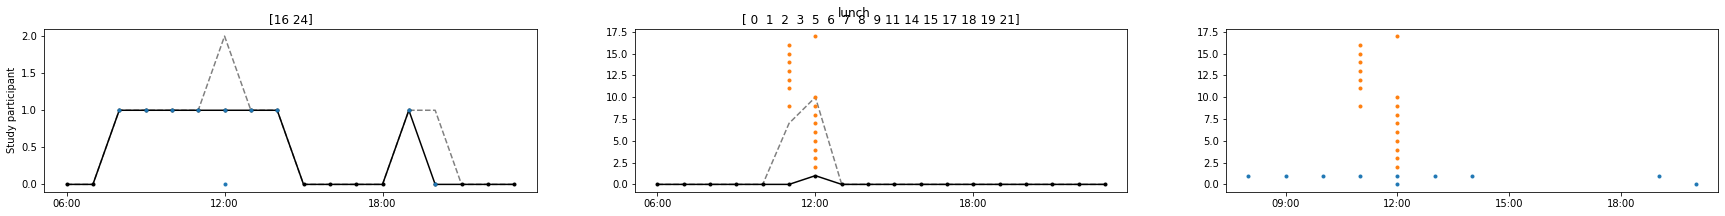

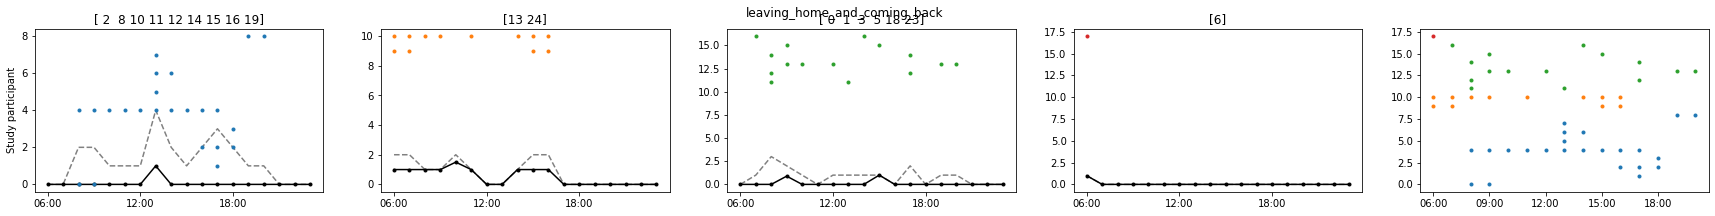

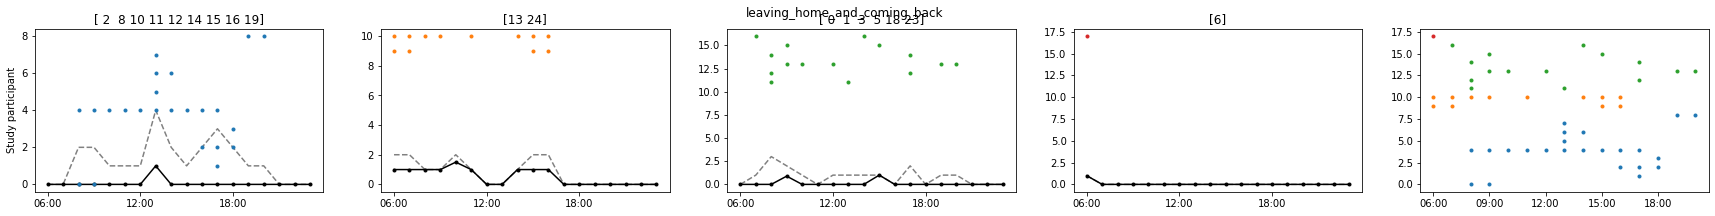

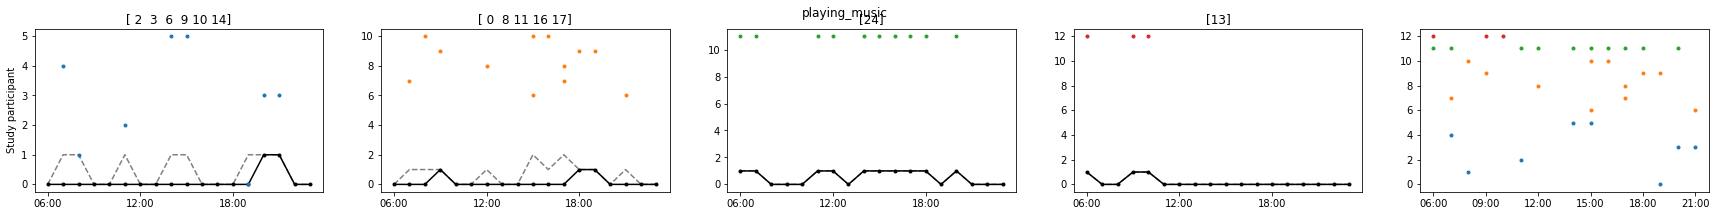

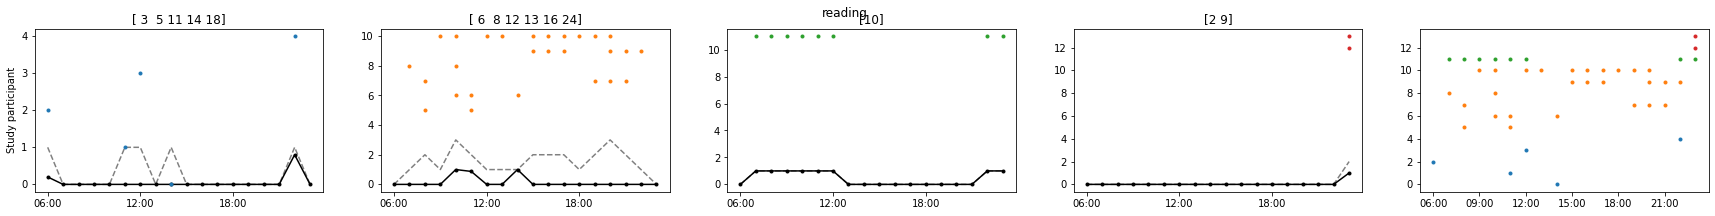

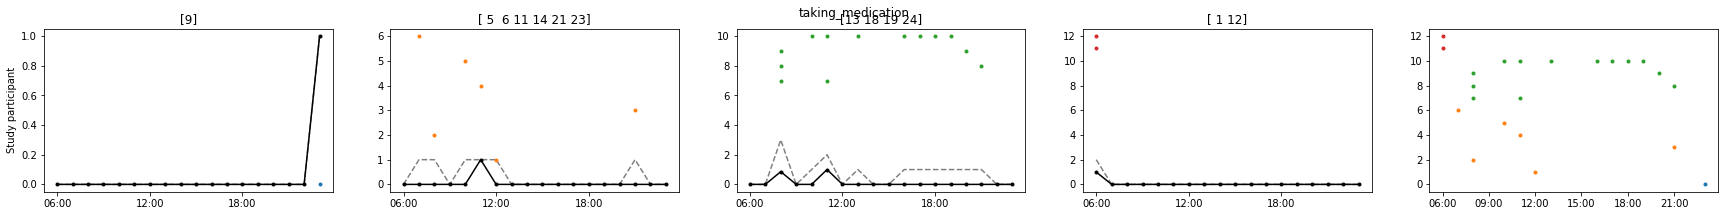

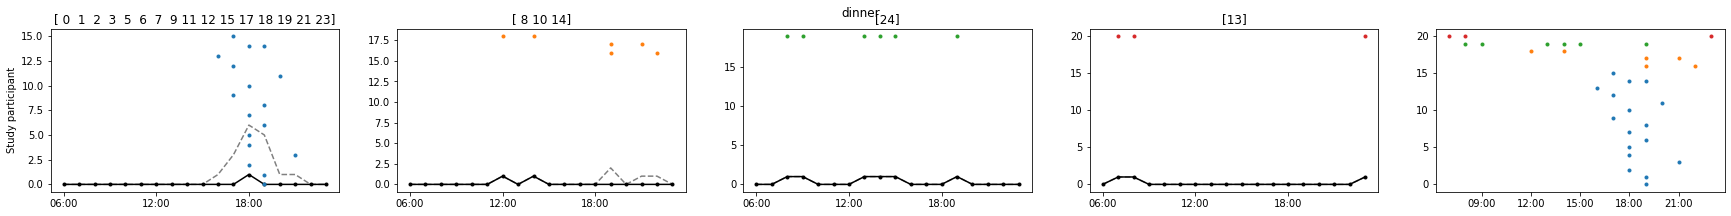

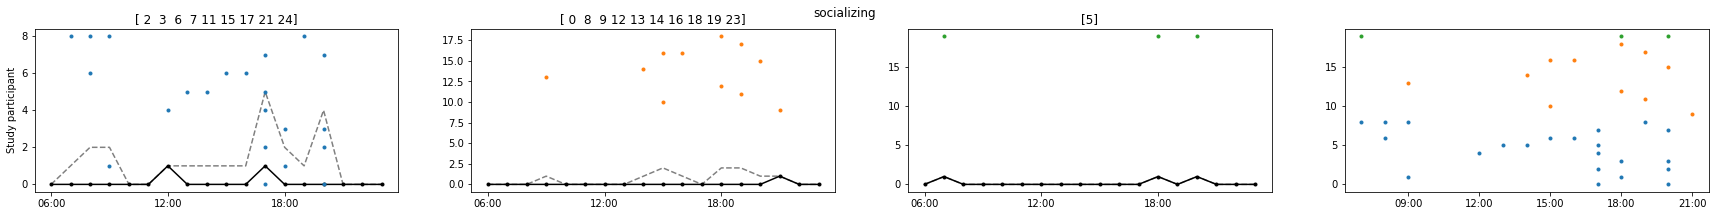

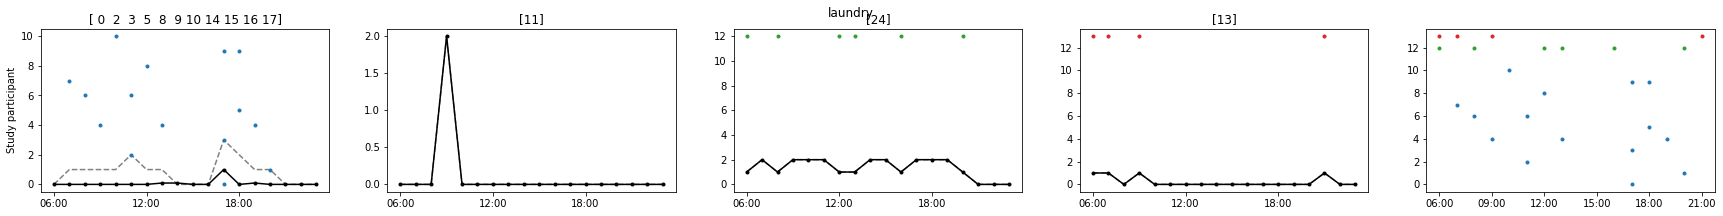

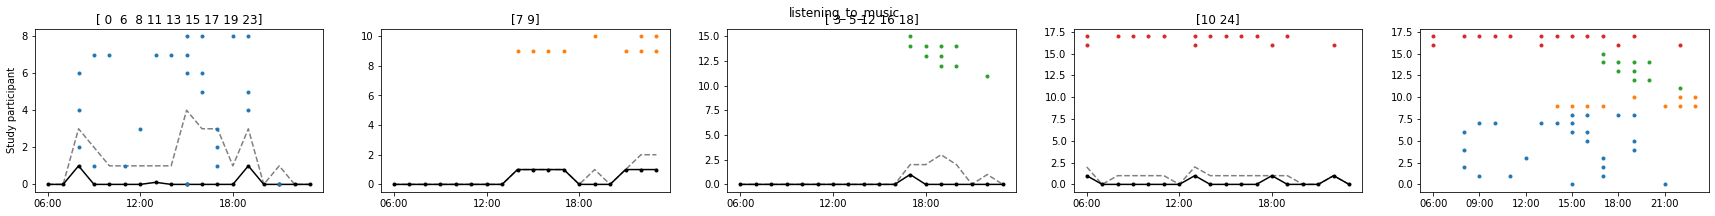

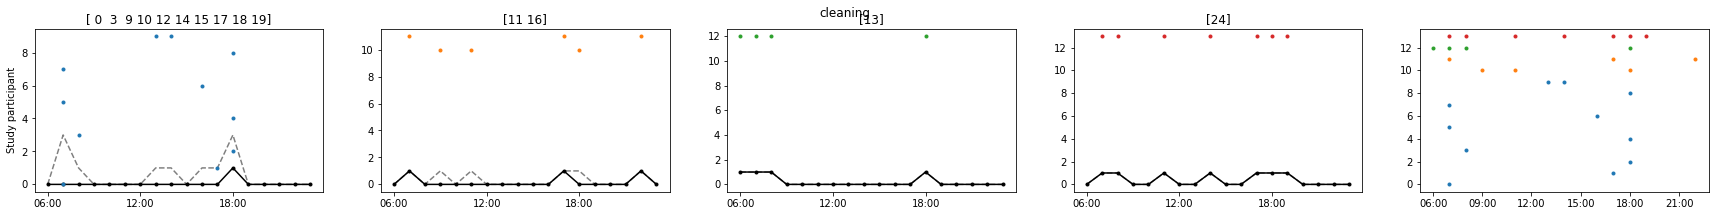

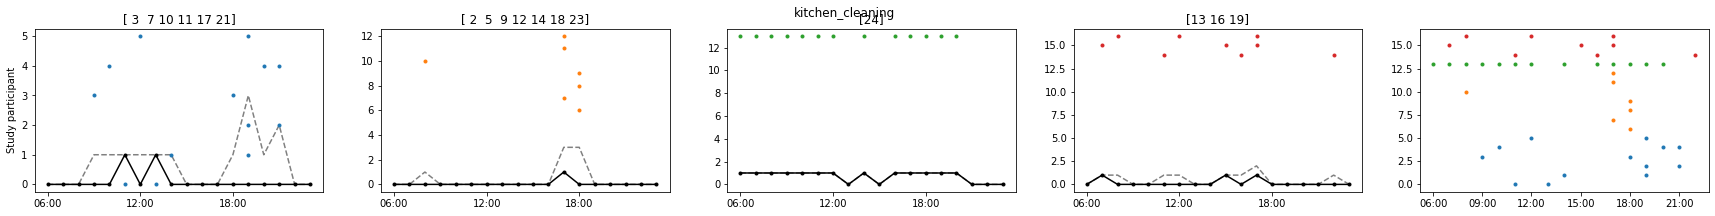

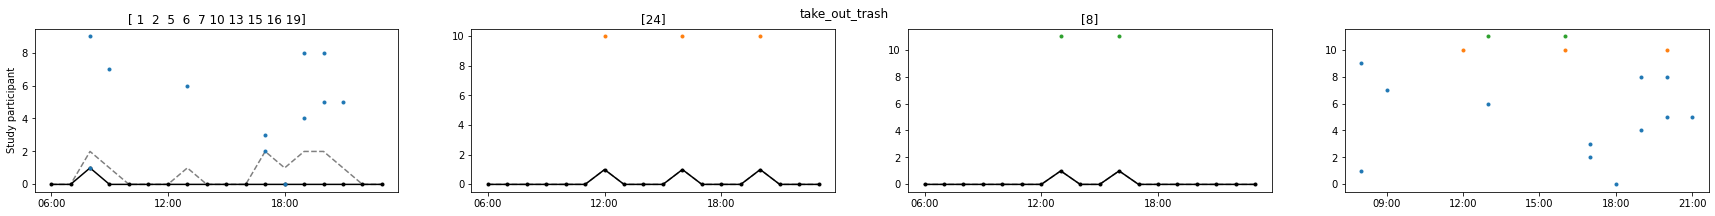

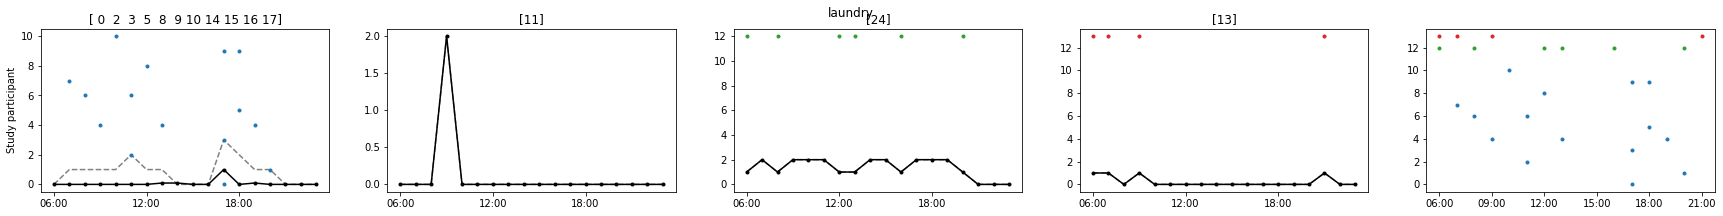

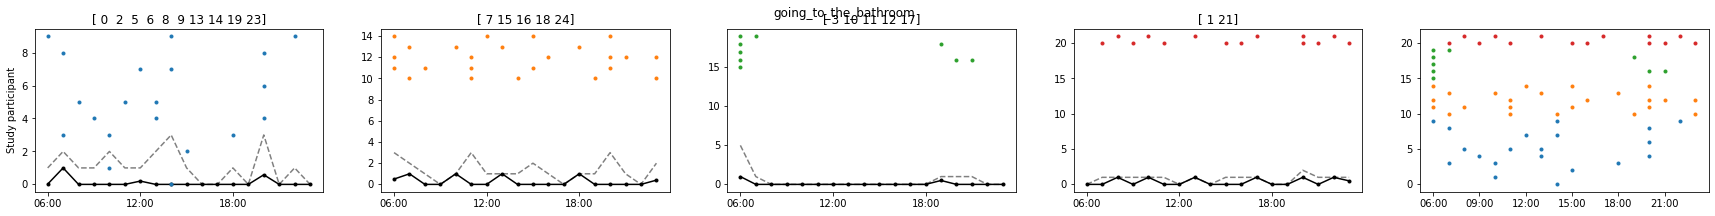

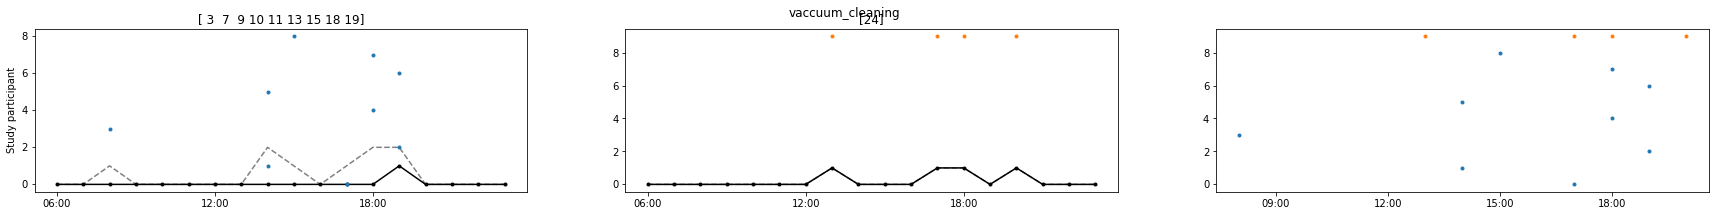

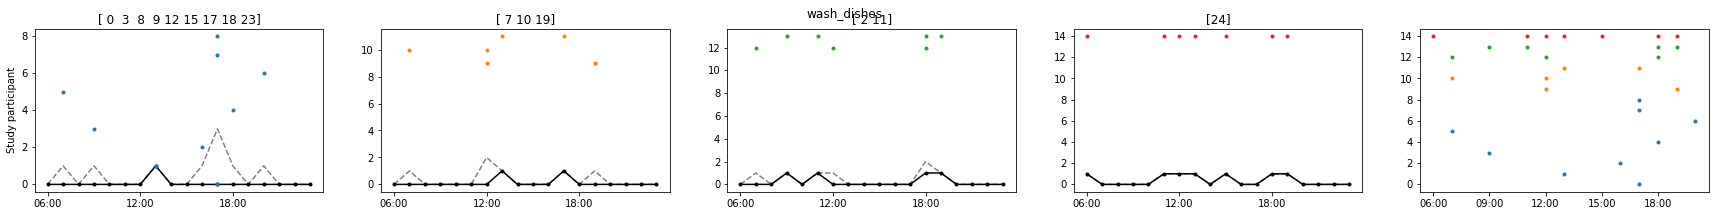

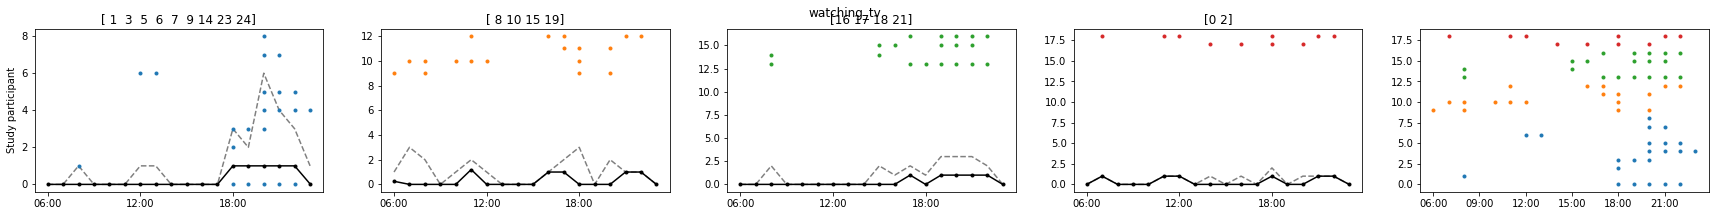

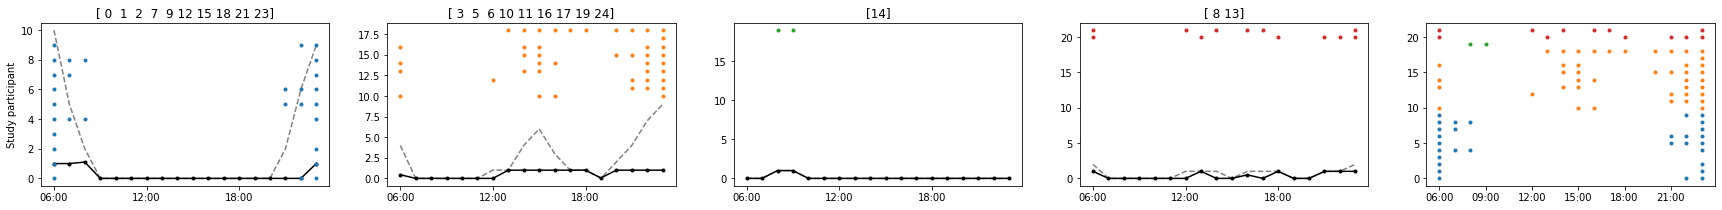

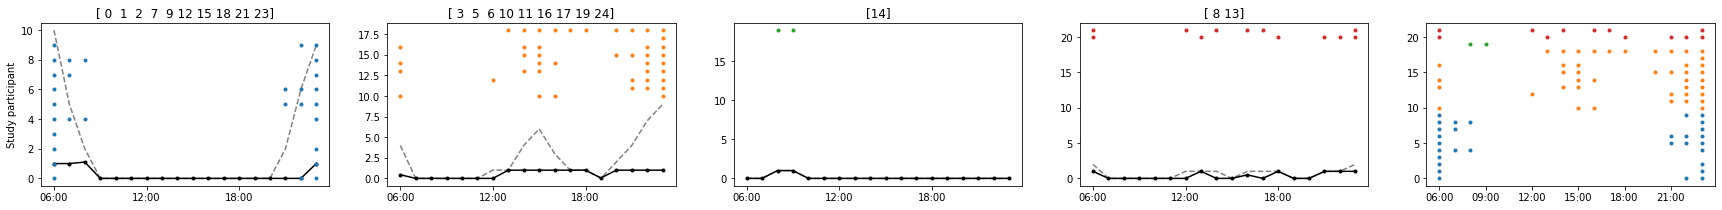

In [ ]:

gap = 0.1

clrs = sns.color_palette()

def plot_together(list_of_freqs, ax, heights = None, color = None):
    width = (1 - gap)/len(list_of_freqs)
    for i,freqs in enumerate(list_of_freqs):
        # start_points = [s-0.5+i*width for s in start_times]
        # ax.bar(start_points, freqs, width=width)
        freq_exist = np.array(start_times)[np.array(freqs) == 1]
        if heights is None:
            h = i
        else:
            h = heights[i]
        ax.plot(freq_exist, freq_exist*0 + h, '.', color=color)


for activity in see_activities:
    cluster_labels = list(set(clustering[activity]['labels']))
    cluster_labels.sort()
    fig,axs = plt.subplots(1,len(cluster_labels)+1)
    fig.set_size_inches(30, 3)
    prev_height = 0
    # plot_together(np.array(list(data_per_activity[activity].values())), axs[-1], heights = np.array(list(data_per_activity[activity].keys())), color = clrs[i])
    axs[-1].set_xticks([s for s in start_times if s%3==0])
    axs[-1].set_xticklabels([time_human(s*60) for s in start_times if s%3==0])
    for i,label in enumerate(cluster_labels):
        cluster_size = len(np.argwhere(clustering[activity]['labels'] == label))
        heights = prev_height + np.arange(cluster_size)
        prev_height += cluster_size
        plot_together(np.array(list(data_per_activity[activity].values()))[clustering[activity]['labels'] == label], axs[-1], heights = heights, color = clrs[i])
        axs[i].plot(start_times, (np.array(list(data_per_activity[activity].values()))[clustering[activity]['labels'] == label]).sum(0), '--', color='gray')
        axs[i].plot(start_times, clustering[activity]['centers'][i,:], '.-k')
        plot_together(np.array(list(data_per_activity[activity].values()))[clustering[activity]['labels'] == label], axs[i], heights = heights, color = clrs[i])
        # plot_together(np.array(list(data_per_activity[activity].values()))[clustering[activity]['labels'] == label], axs[-1], heights = np.array(list(data_per_activity[activity].keys()))[clustering[activity]['labels'] == label], color = clrs[i])
        # plot_together(np.array(list(data_per_activity[activity].values()))[clustering[activity]['labels'] == label], axs[i], heights = np.array(list(data_per_activity[activity].keys()))[clustering[activity]['labels'] == label], color = clrs[i])
        axs[i].set_title(str(np.array(list(data_per_activity[activity].keys()))[clustering[activity]['labels'] == label]))
        axs[i].set_xticks([s for s in start_times if s%6==0])
        axs[i].set_xticklabels([time_human(s*60) for s in start_times if s%6==0])
    axs[0].set_ylabel('Study participant')
    fig.suptitle(activity)
    # fig.tight_layout()
    plt.show()

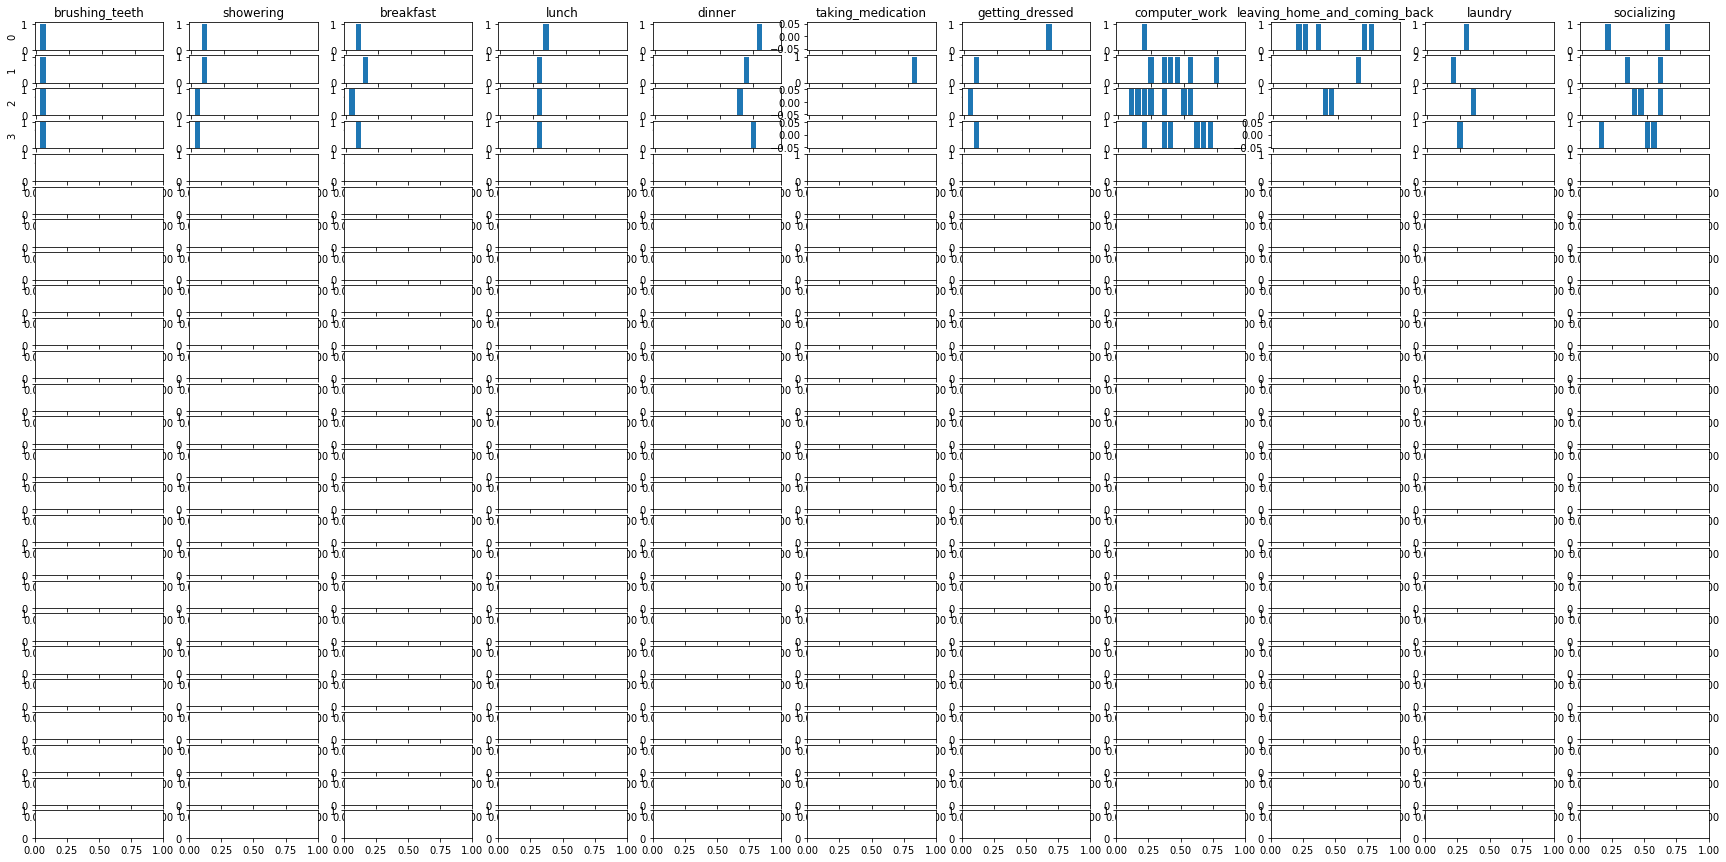

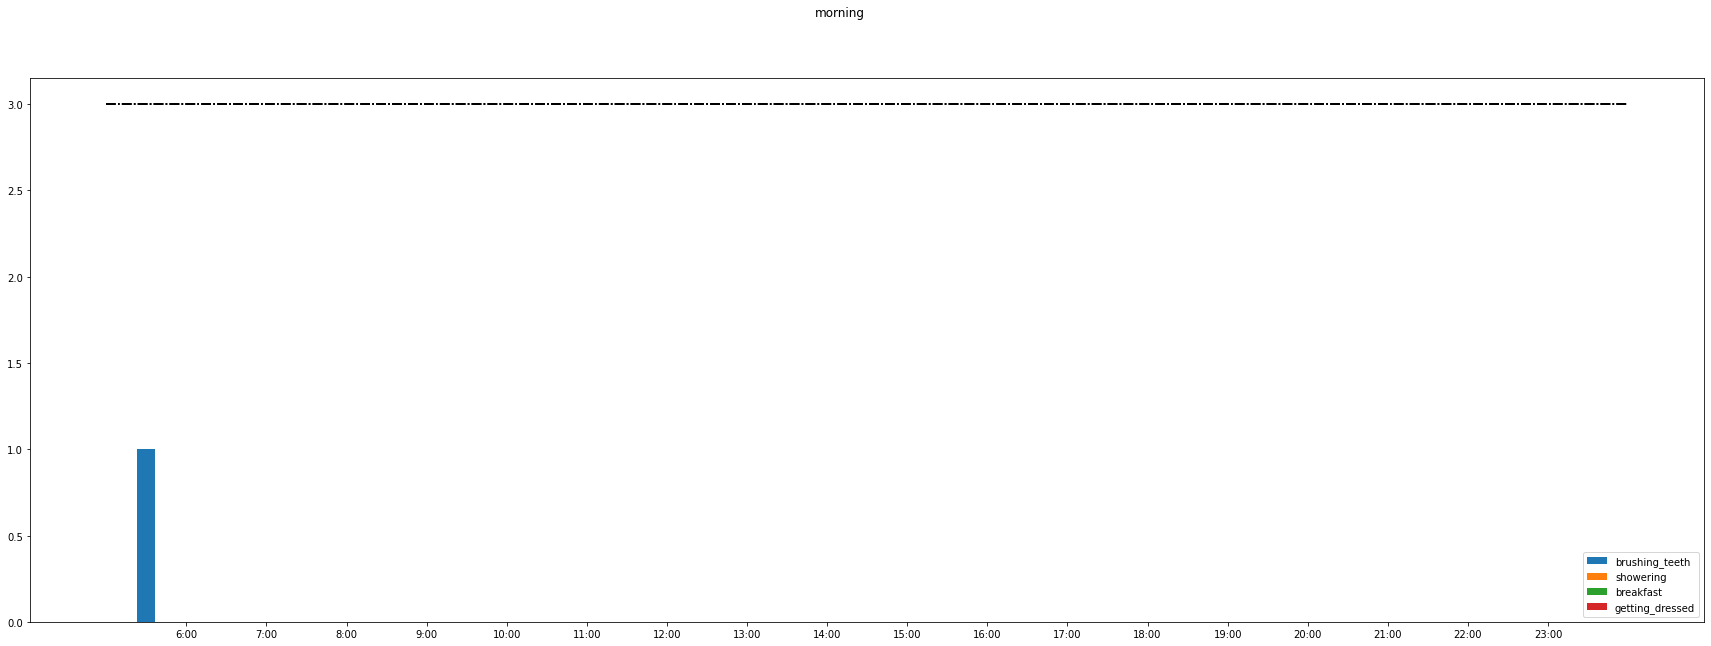

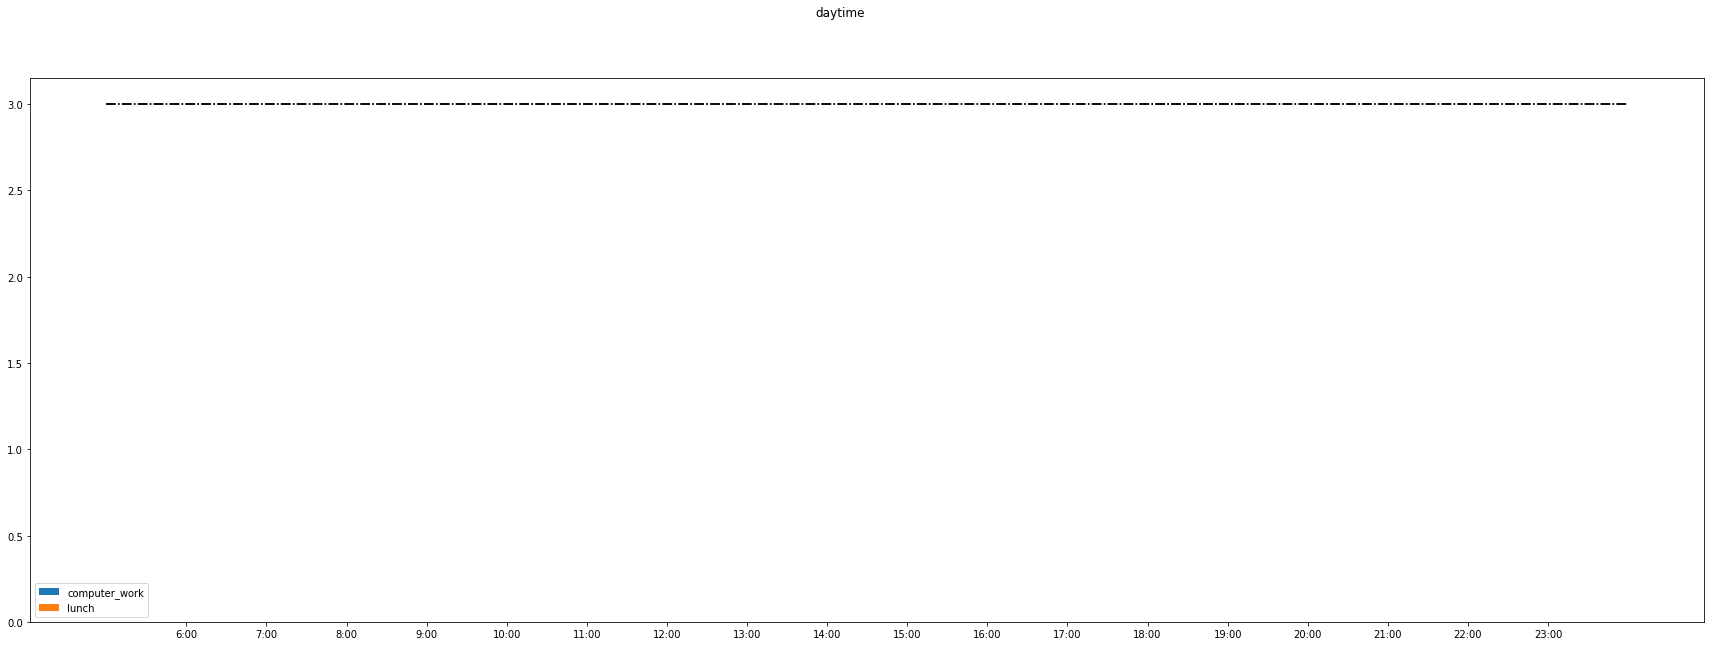

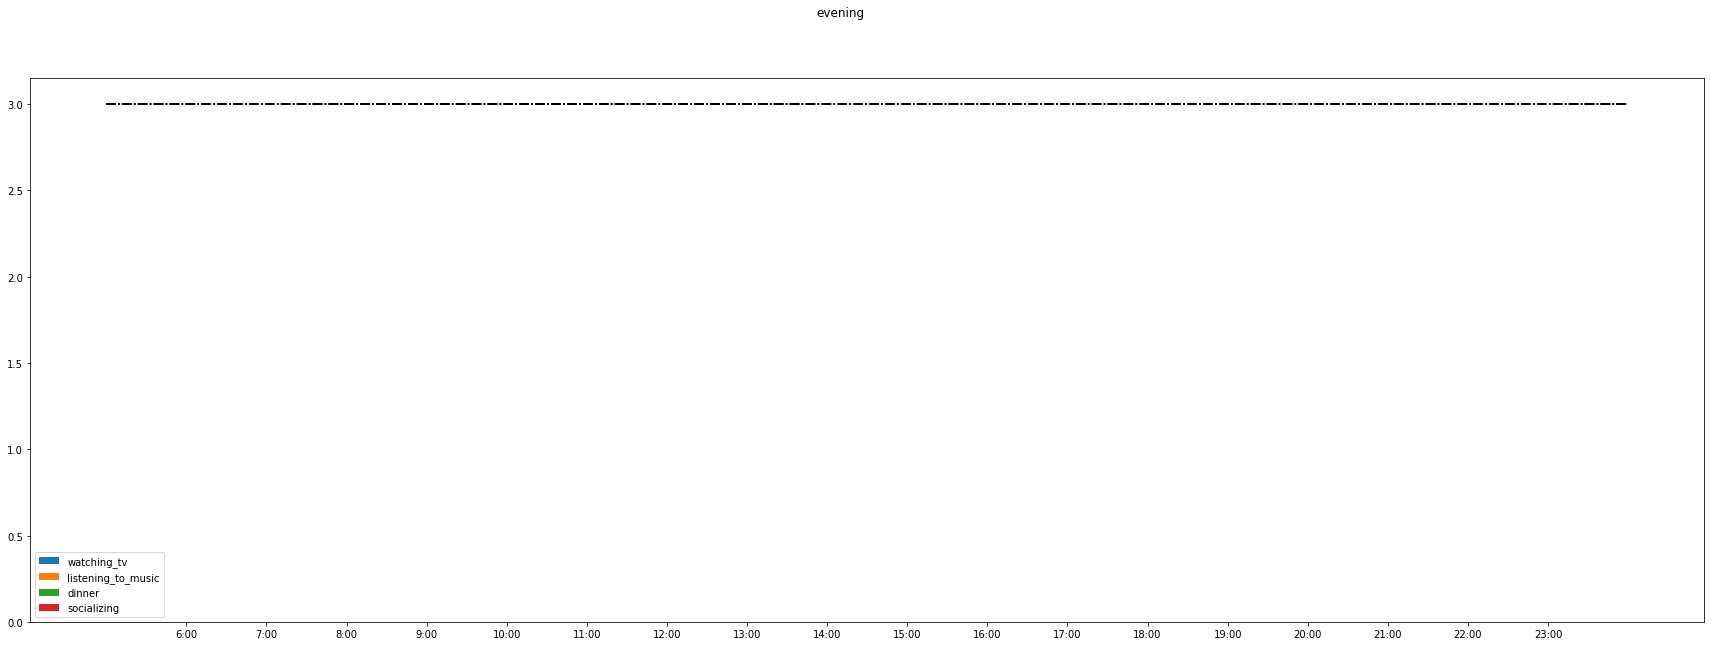

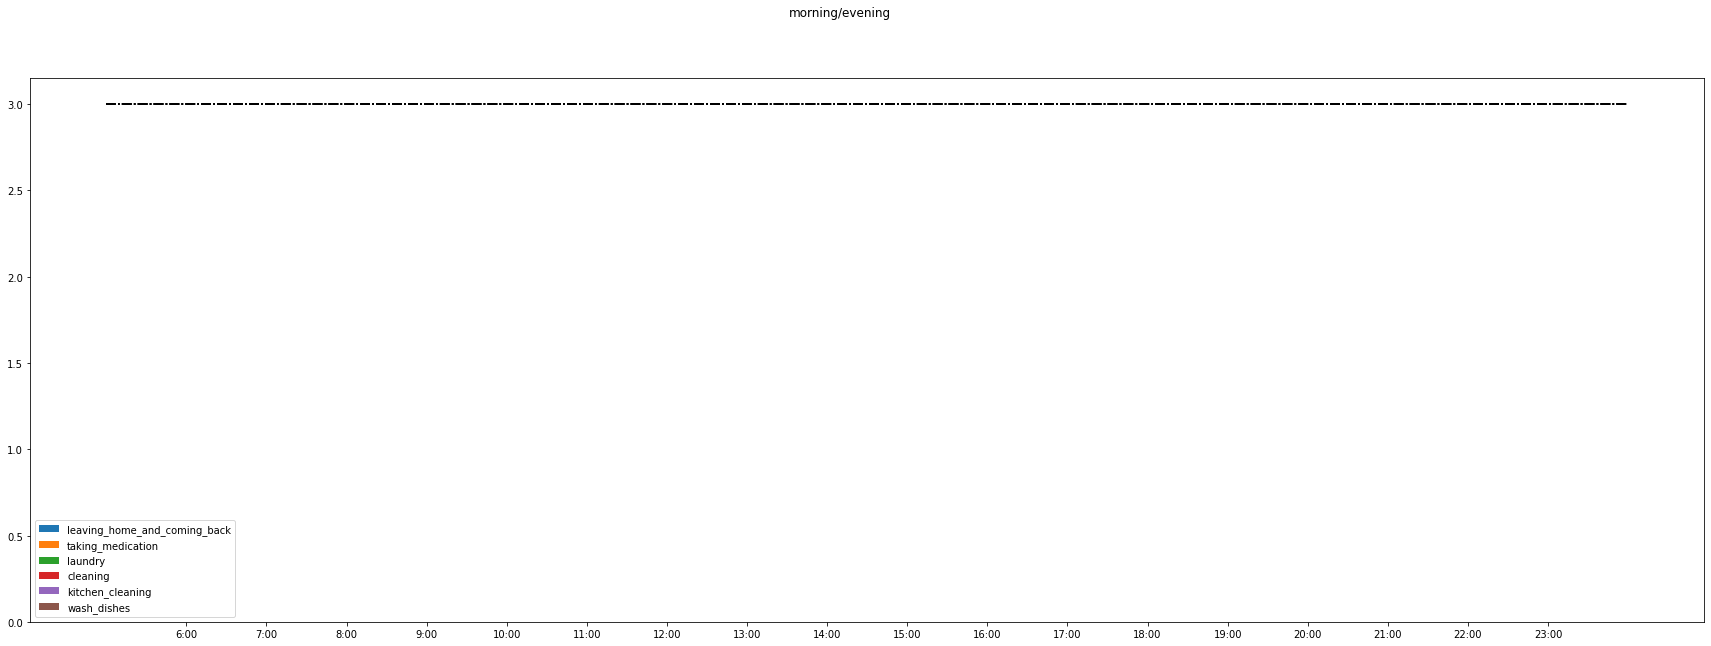

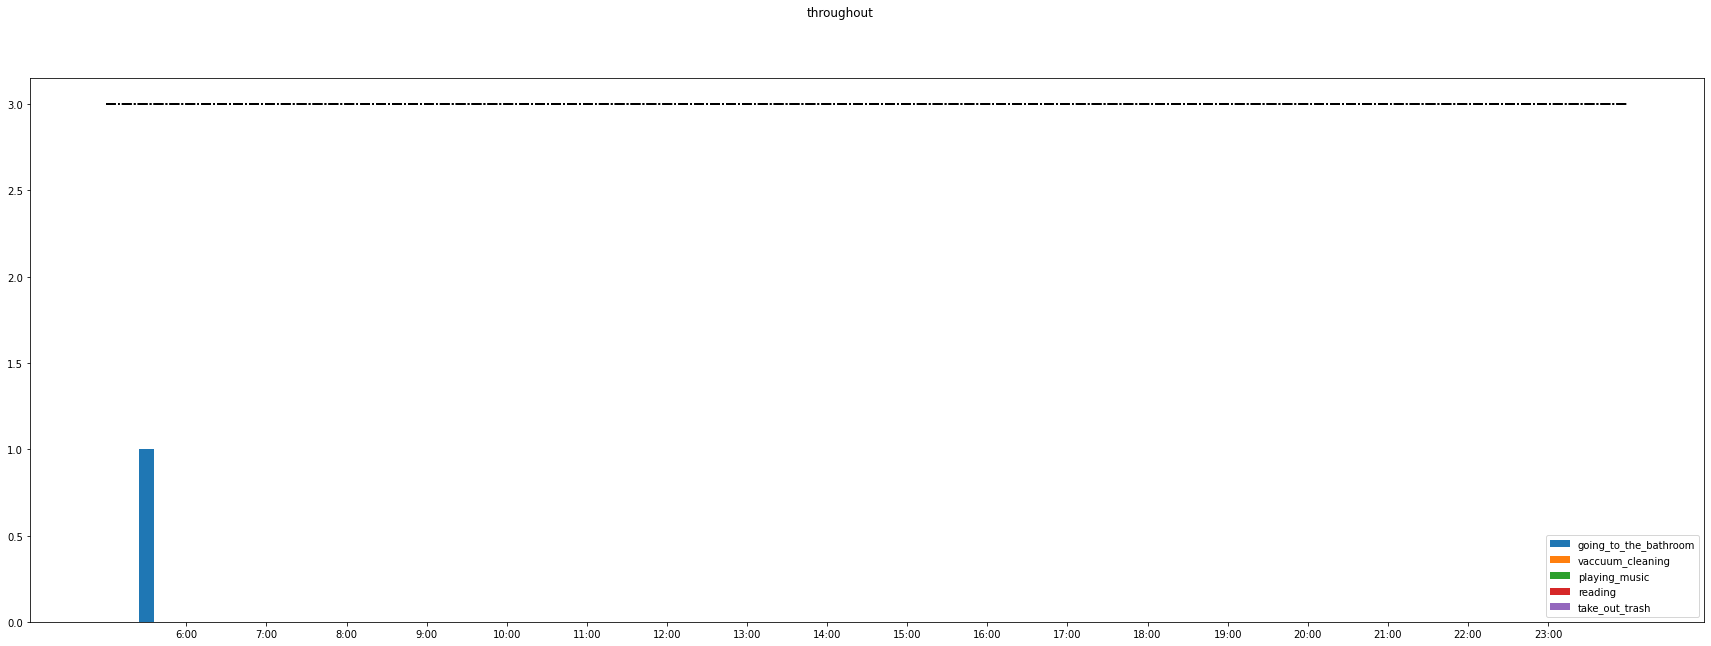

In [63]:
sampler = ScheduleSampler(filter_num=0, idle_sampling_factor=idle_sampling_factor)

groups = {}
groups['morning'] = ['brushing_teeth', 'showering', 'breakfast', 'getting_dressed']
groups['daytime'] = ['computer_work', 'lunch']
groups['evening'] = ['watching_tv', 'listening_to_music', 'dinner', 'socializing']
groups['morning/evening'] = ['leaving_home_and_coming_back', 'taking_medication', 'laundry', 'cleaning', 'kitchen_cleaning', 'wash_dishes']
groups['throughout'] = ['going_to_the_bathroom', 'vaccuum_cleaning', 'playing_music', 'reading', 'take_out_trash']

clrs = sns.color_palette()

gap = 0.1
for name,group in groups.items():
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 10)
    num_act = len(group)
    width = (1 - gap)/num_act
    for i, act in enumerate(group):
        freq = sampler.activity_histograms[act]
        start_points = [f-0.5+i*width for f in freq.keys()]
        ax.bar(start_points, [max(0, f-filter_num) for f in freq.values()], label=act, width=width, color=clrs[i])
        ax.plot([start_times[0]-1, start_times[-1]+1], [filter_num,filter_num], '-.k')
        # ax.plot(freq.keys(), [max(0, f-filter_num) for f in freq.values()], label=act, color=clrs[i])
    ax.set_xticks(start_times)
    ax.set_xticklabels([str(s)+':00' for s in start_times])
    fig.suptitle(name)
    plt.legend()
    plt.show()

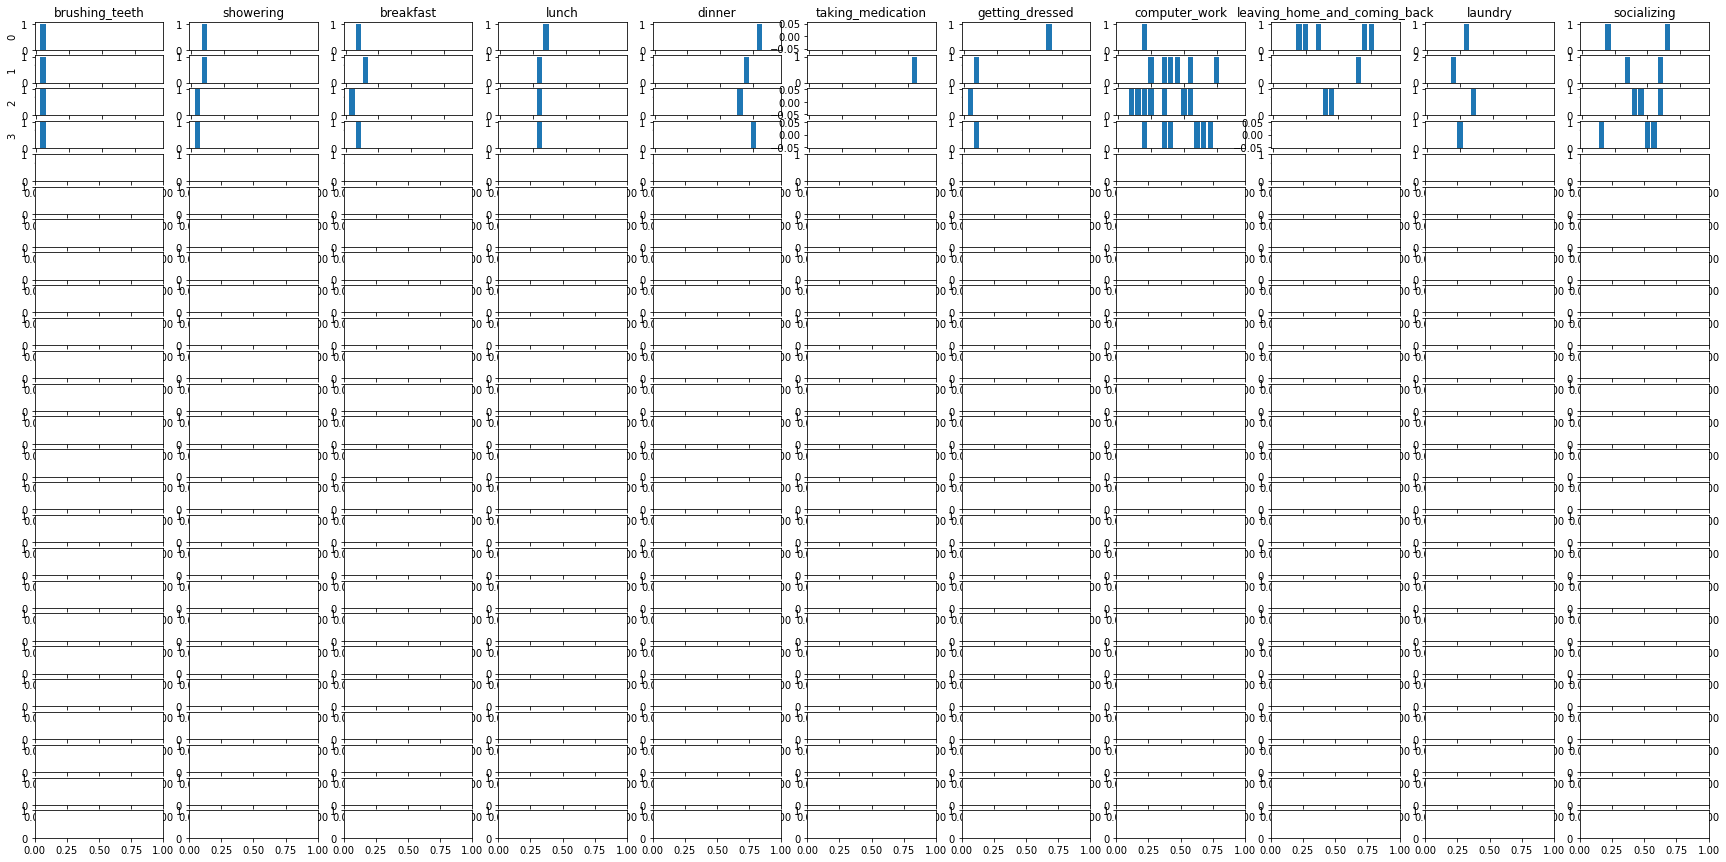

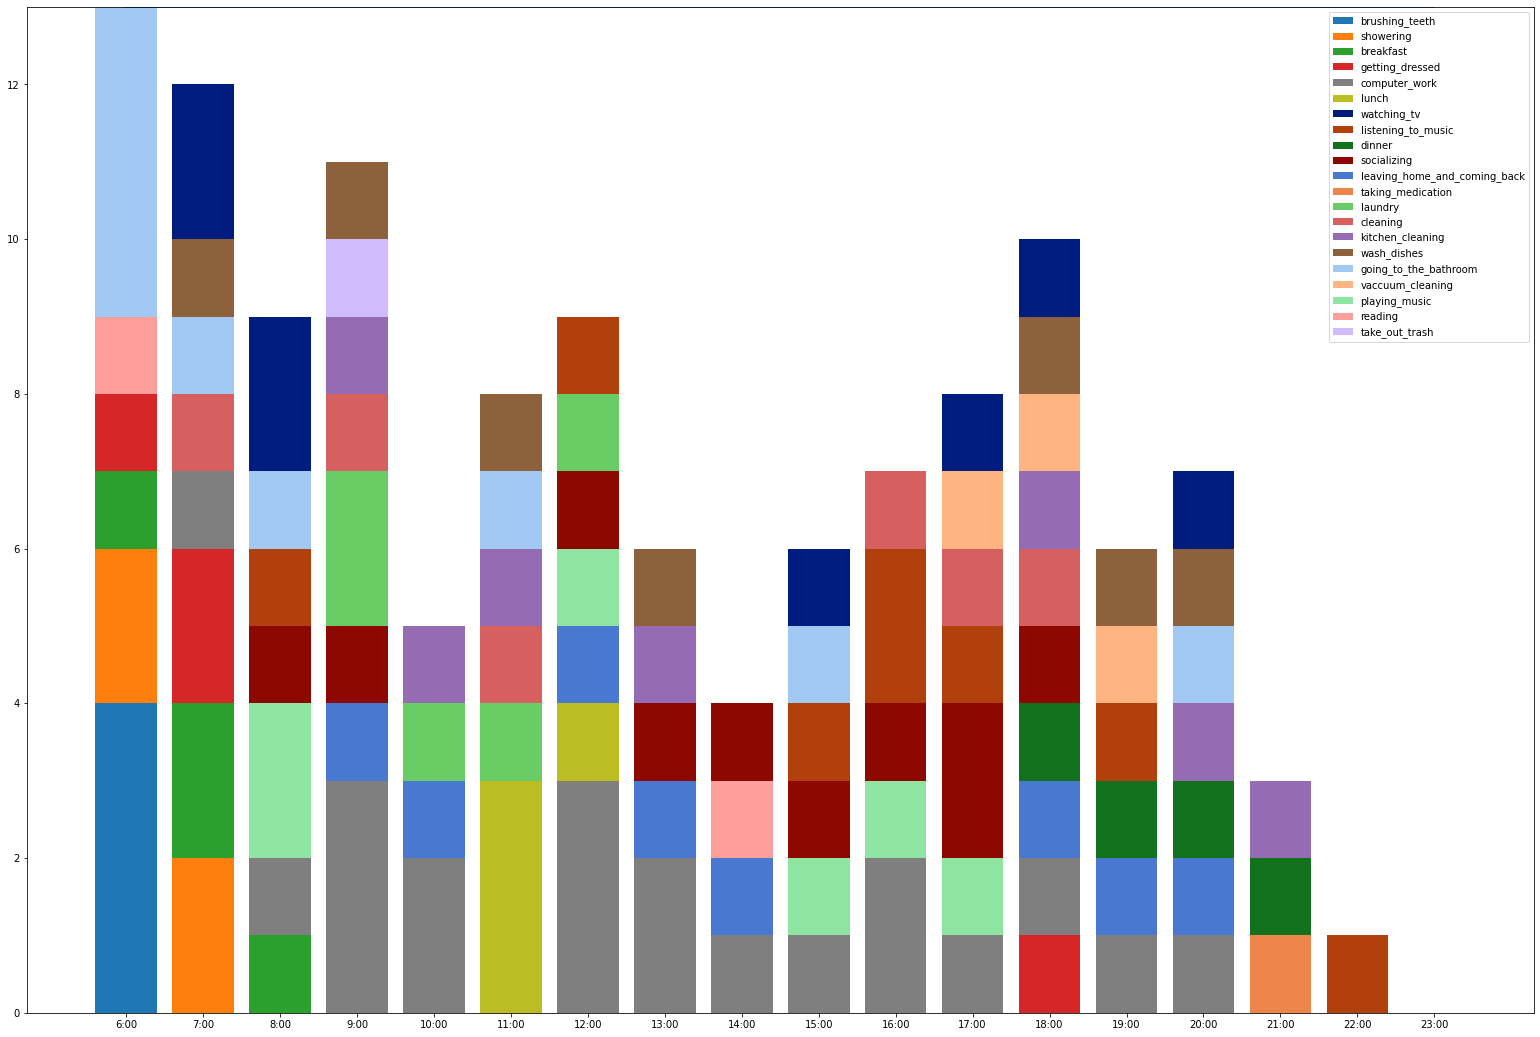

In [65]:
sampler = ScheduleSampler(filter_num=0, idle_sampling_factor=idle_sampling_factor)

clrs = [sns.color_palette(), sns.color_palette()[-3:], sns.color_palette("dark"), sns.color_palette("muted"), sns.color_palette("pastel")]
fig, ax = plt.subplots()
fig.set_size_inches(27, 18.5)
for i,group in enumerate(groups.values()):
    for j, activity in enumerate(group):
        freq = sampler.activity_histograms[activity]
        d = [sampler.activity_threshold[st][activity][1] - sampler.activity_threshold[st][activity][0] for st in start_times]
        ax.bar(freq.keys(), d, label=activity, bottom=[sampler.activity_threshold[st][activity][0] for st in start_times], color=clrs[i][j])
ax.plot([start_times[0], start_times[-1]], [sampler.sampling_range,sampler.sampling_range])
ax.set_xticks(start_times)
ax.set_xticklabels([str(s)+':00' for s in start_times])
plt.legend()
plt.show()

In [59]:
t = 7.5 * 60
print(sampler(t))


None


In [60]:
print(sampler.sample_time_for('breakfast')/60)

6.416666666666667


In [61]:
print(sampler.sample_time_for('breakfast')/60)


6.333333333333333
